In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import plotly

from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from itertools import product

# Set random seed for reproducibility
torch.manual_seed(0)

# Torch version
torch.__version__

'2.4.1+cu124'

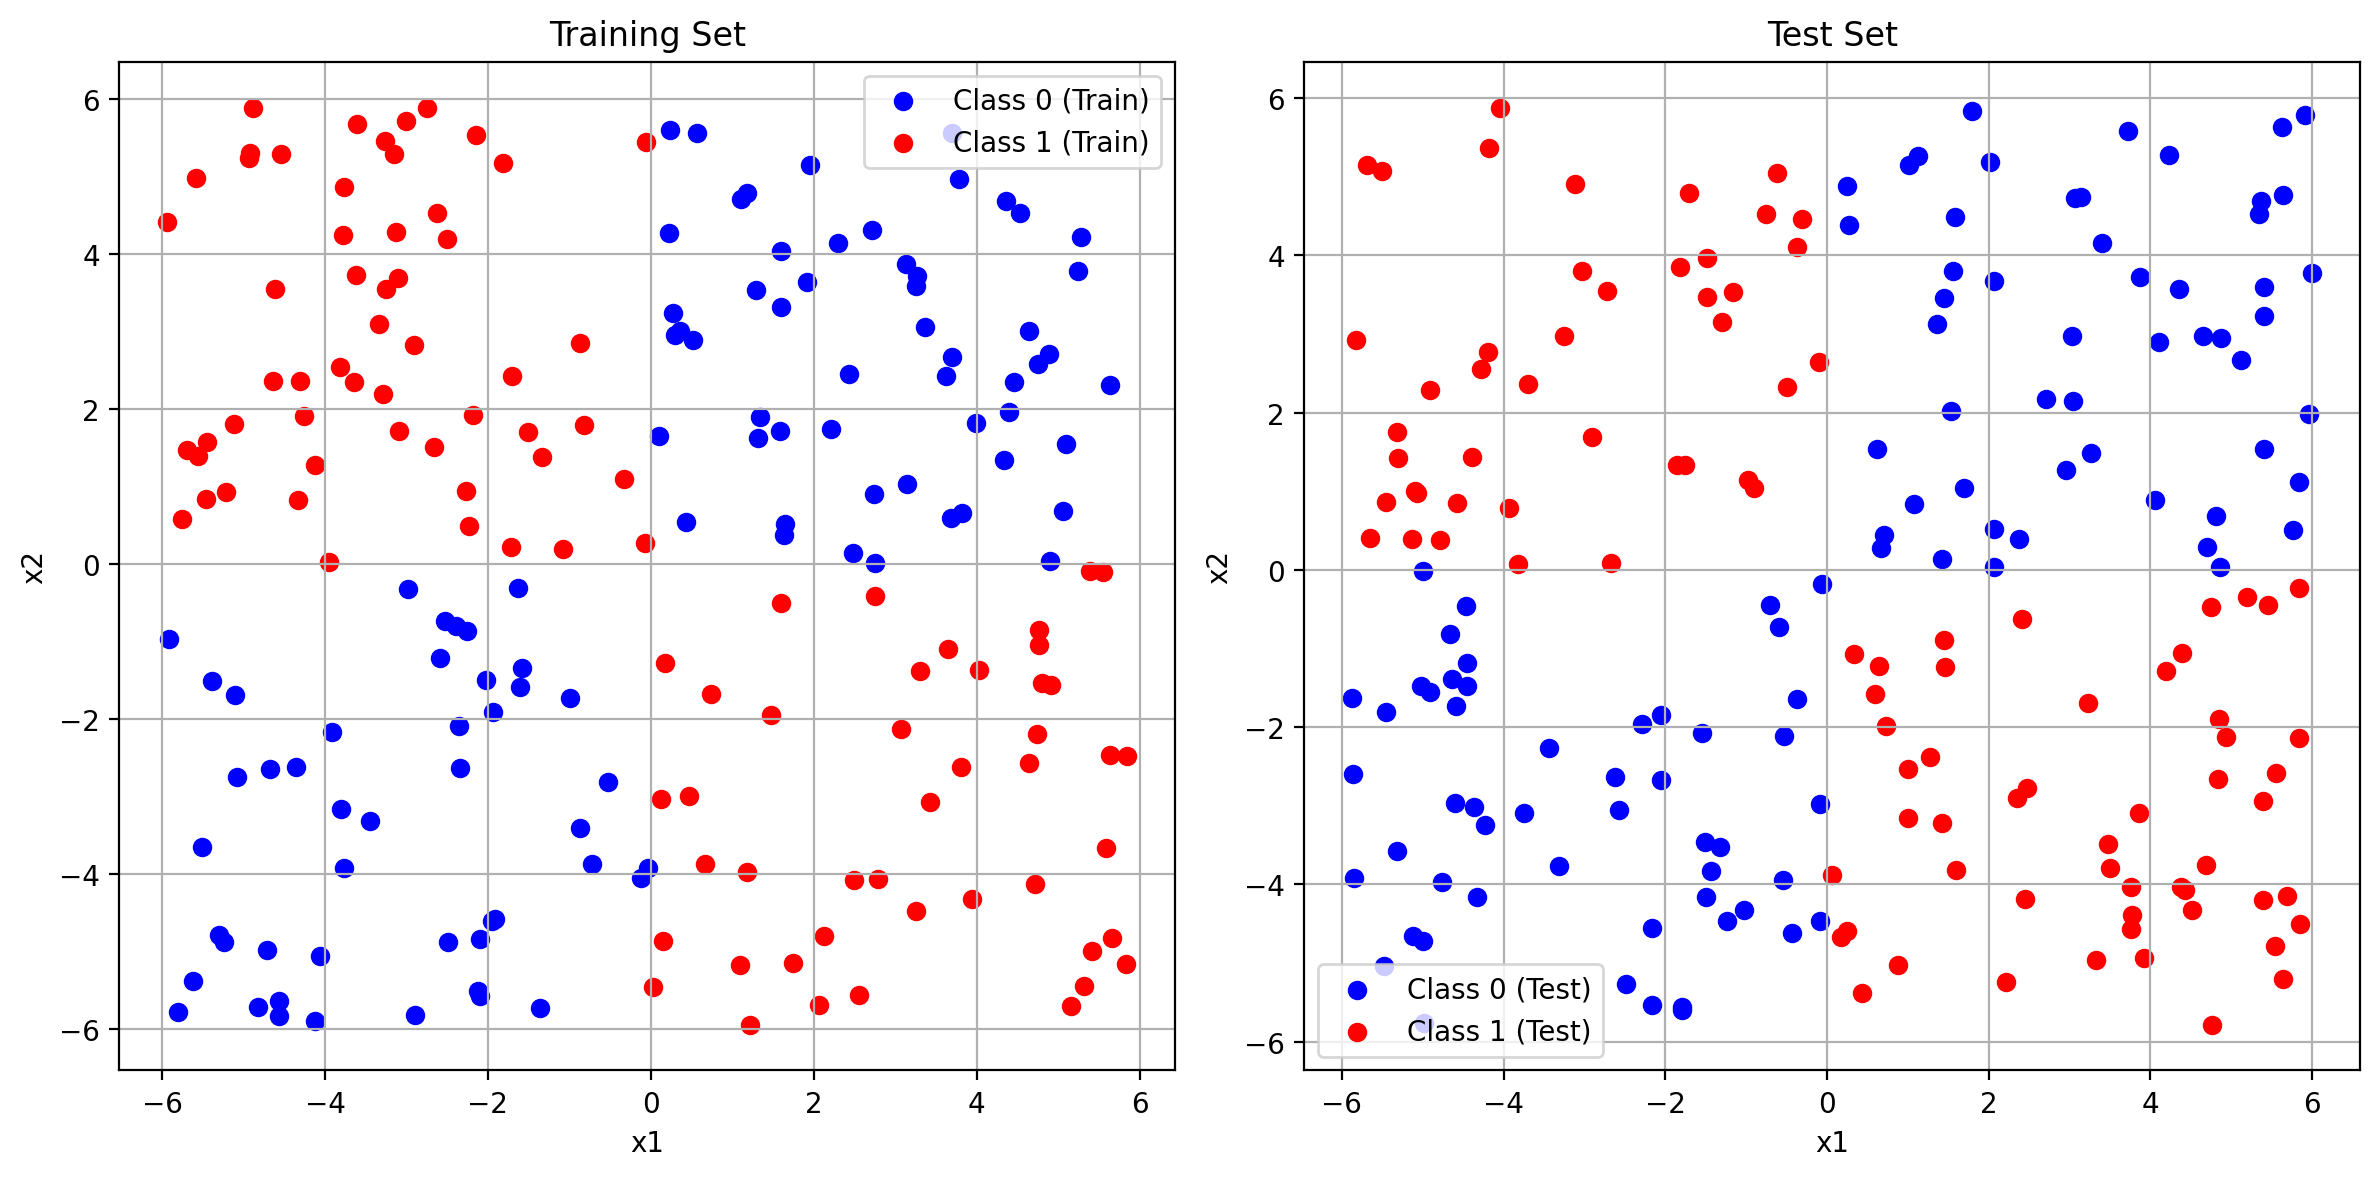

In [ ]:
np.random.seed(42)

num_train_samples = 200
num_test_samples = 200

# Training set
x1_train = np.random.uniform(-6, 6, num_train_samples)
x2_train = np.random.uniform(-6, 6, num_train_samples)
x1_train_reshaped = x1_train.reshape(-1, 1) # Reshaping to a column vector
x2_train_reshaped = x2_train.reshape(-1, 1) # Reshape to a column vector
concatenated_x_train = np.concatenate((x1_train_reshaped,x2_train_reshaped), axis=1)
y_train = np.logical_xor(x1_train > 0, x2_train > 0).astype(int) # Labels according to XOR function

# Test set
x1_test = np.random.uniform(-6, 6, num_test_samples)
x2_test = np.random.uniform(-6, 6, num_test_samples)
x1_test_reshaped = x1_test.reshape(-1, 1)
x2_test_reshaped = x2_test.reshape(-1, 1)
concatenated_x_test = np.concatenate((x1_test_reshaped,x2_test_reshaped), axis=1)
y_test = np.logical_xor(x1_test > 0, x2_test > 0).astype(int)
# Plot the data
plt.figure(figsize=(12, 6))

# Training set
plt.subplot(1, 2, 1)
plt.scatter(x1_train[y_train==0], x2_train[y_train==0], c='b', label='Class 0 (Train)')
plt.scatter(x1_train[y_train==1], x2_train[y_train==1], c='r', label='Class 1 (Train)')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Training Set')
plt.legend()
plt.grid(True)

# Test set
plt.subplot(1, 2, 2)
plt.scatter(x1_test[y_test==0], x2_test[y_test==0], c='b', label='Class 0 (Test)')
plt.scatter(x1_test[y_test==1], x2_test[y_test==1], c='r', label='Class 1 (Test)')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Test Set')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
targets_train = torch.tensor(y_train, dtype=torch.float32)
targets_train = targets_train.reshape(-1, 1)

targets_test = torch.tensor(y_test, dtype=torch.float32)
targets_test = targets_test.reshape(-1, 1)

In [ ]:
torch.manual_seed(42)
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x



# a

In [ ]:
def train_model(model, criterion, optimizer, x_train, y_train, num_epochs, batch_size):
    for epoch in range(num_epochs):
        for i in range(0, x_train.shape[0], batch_size):
            x = torch.tensor(x_train, dtype=torch.float32)[i:i+batch_size]
            y = y_train[i:i+batch_size]

            outputs = model.forward(x)

            loss = criterion(outputs,y)

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

    return model

In [ ]:
def accuracy(predicted,true_labels):
    result = torch.where(predicted > 0, torch.tensor(1), torch.tensor(0))
    accuracy = (result == true_labels).sum().item() / len(true_labels)
    return accuracy

In [ ]:
torch.manual_seed(1)
model_to_learn_no_reg = MLP(2,4,1)
learned_model_no_reg = train_model(model_to_learn_no_reg, nn.BCEWithLogitsLoss(), optim.SGD(model_to_learn_no_reg.parameters(), lr=0.1), concatenated_x_train, targets_train, 1000, 10)
a1 = accuracy(learned_model_no_reg.forward(torch.tensor(concatenated_x_test, dtype=torch.float32)), targets_test)
print(f'Accuracy on the testing set: {a1*100:.2f} %')

Epoch 0, Loss: 0.7036072015762329
Epoch 100, Loss: 0.004863427486270666
Epoch 200, Loss: 0.0025894378777593374
Epoch 300, Loss: 0.0015530871460214257
Epoch 400, Loss: 0.0012337910011410713
Epoch 500, Loss: 0.0010261894203722477
Epoch 600, Loss: 0.0007070324500091374
Epoch 700, Loss: 0.000537283078301698
Epoch 800, Loss: 0.00044234361848793924
Epoch 900, Loss: 0.0003803168947342783
Accuracy on the testing set: 99.00 %


In [ ]:
# plot the decision surface for the obtained model.

def predict_plot_grid(model,s):
    x1 = np.linspace(-6, 6, s)
    x2 = np.linspace(-6, 6, s)
    xx1, xx2 = np.meshgrid(x1, x2)
    X = np.column_stack((xx1.ravel(), xx2.ravel()))
    y = model.forward(torch.tensor(X, dtype=torch.float32)).detach().numpy().reshape(s, s)
    return xx1, xx2, y
# plot the decision surface for the obtained model.

def plot_decision_surface(model, x_train, y_train, x_test, y_test, s=100):
    print(predict_plot_grid(model,s))
    xx1, xx2, y = predict_plot_grid(model,s)
    plt.figure(figsize=(12, 6))

    # Training set
    plt.subplot(1, 2, 1)
    plt.contourf(xx1, xx2, y, alpha=0.5)
    plt.scatter(x_train[y_train==0][:,0], x_train[y_train==0][:,1], c='b', label='Class 0 (Train)')
    plt.scatter(x_train[y_train==1][:,0], x_train[y_train==1][:,1], c='r', label='Class 1 (Train)')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title('Training Set')
    plt.legend()
    plt.grid(True)

    # Test set
    plt.subplot(1, 2, 2)
    plt.contourf(xx1, xx2, y, alpha=0.5)
    plt.scatter(x_test[y_test==0][:,0], x_test[y_test==0][:,1], c='b', label='Class 0 (Test)')
    plt.scatter(x_test[y_test==1][:,0], x_test[y_test==1][:,1], c='r', label='Class 1 (Test)')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title('Test Set')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

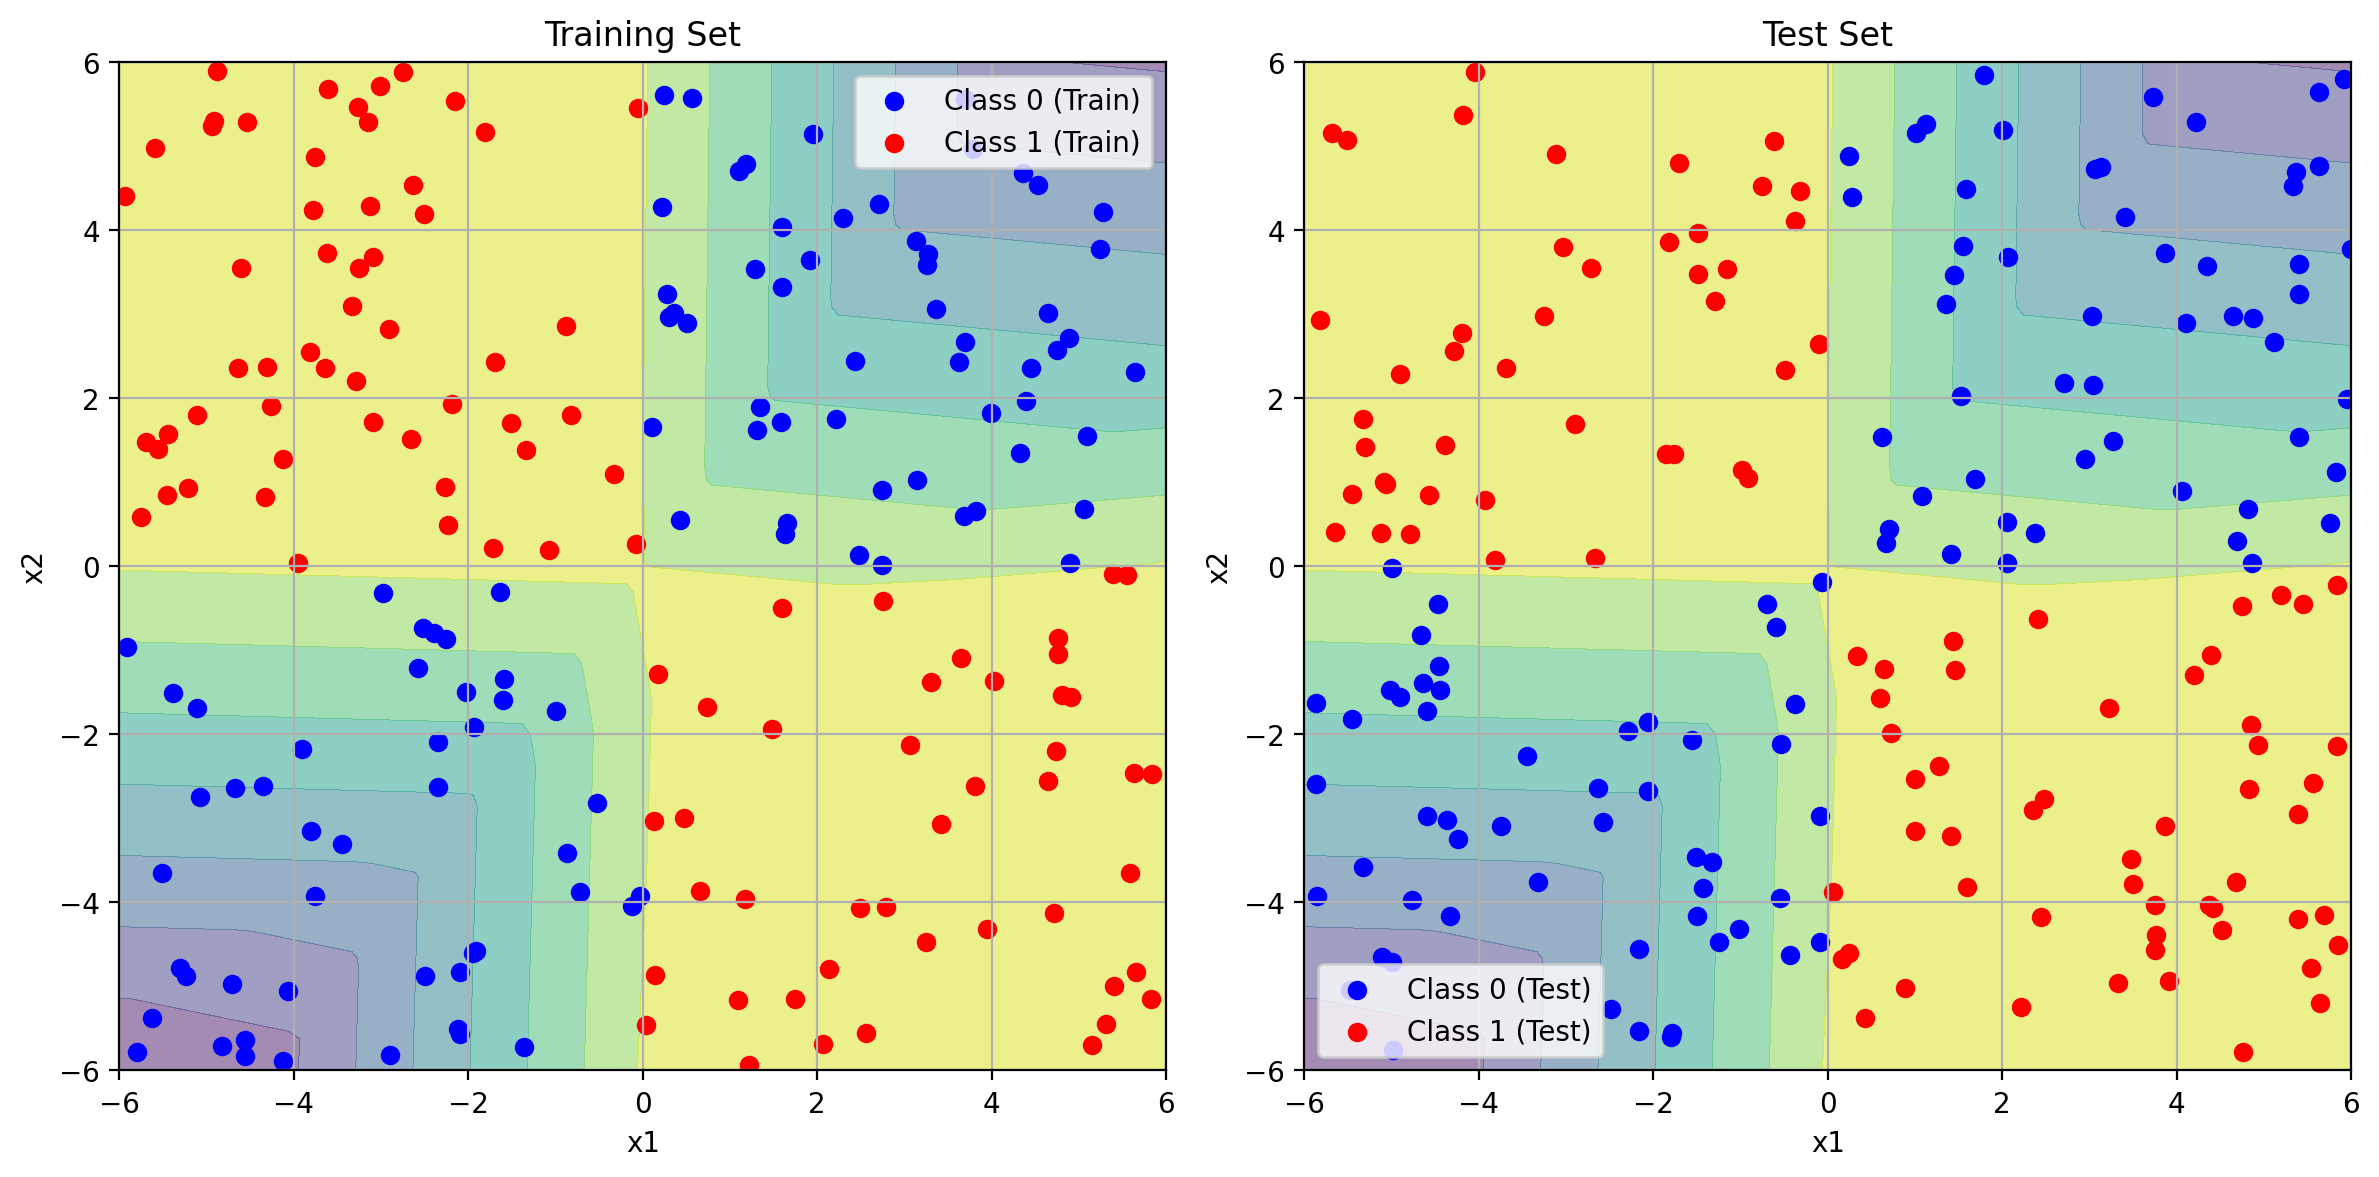

In [ ]:
plot_decision_surface(learned_model_no_reg, concatenated_x_train, y_train, concatenated_x_test, y_test, s=100)

# b

In [ ]:
def train_model_with_l1_reg(model, criterion, optimizer, x_train, y_train, num_epochs, batch_size, regularisation_coeff):
    for epoch in range(num_epochs):
        for i in range(0, x_train.shape[0], batch_size):
            x = torch.tensor(x_train, dtype=torch.float32)[i:i+batch_size]
            y = y_train[i:i+batch_size]
            outputs = model.forward(x)

            loss = criterion(outputs,y)
            l1_regularization = torch.tensor(0.)
            for param in model.parameters():
                l1_regularization += torch.norm(param, p=1)
            loss += regularisation_coeff * l1_regularization

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

    return model

In [ ]:
def accuracy(predicted,true_labels):
    result = torch.where(predicted > 0, torch.tensor(1), torch.tensor(0))
    accuracy = (result == true_labels).sum().item() / len(true_labels)
    return accuracy

In [ ]:
torch.manual_seed(1)
model_to_learn_l1 = MLP(2,4,1)
learned_model_l1 = train_model_with_l1_reg(model_to_learn_l1, nn.BCEWithLogitsLoss(), optim.SGD(model_to_learn_l1.parameters(), lr=0.01), concatenated_x_train, targets_train, 1000, 20, 0.001)
a2 = accuracy(learned_model_l1.forward(torch.tensor(concatenated_x_test, dtype=torch.float32)), targets_test)
print(f'Accuracy on the testing set: {a2*100:.2f} %')

Epoch 0, Loss: 0.8491241931915283
Epoch 100, Loss: 0.48550406098365784
Epoch 200, Loss: 0.15237091481685638
Epoch 300, Loss: 0.09395831823348999
Epoch 400, Loss: 0.072307288646698
Epoch 500, Loss: 0.06161452829837799
Epoch 600, Loss: 0.05523955821990967
Epoch 700, Loss: 0.051115281879901886
Epoch 800, Loss: 0.04828962683677673
Epoch 900, Loss: 0.04628869891166687
Accuracy on the testing set: 99.50 %


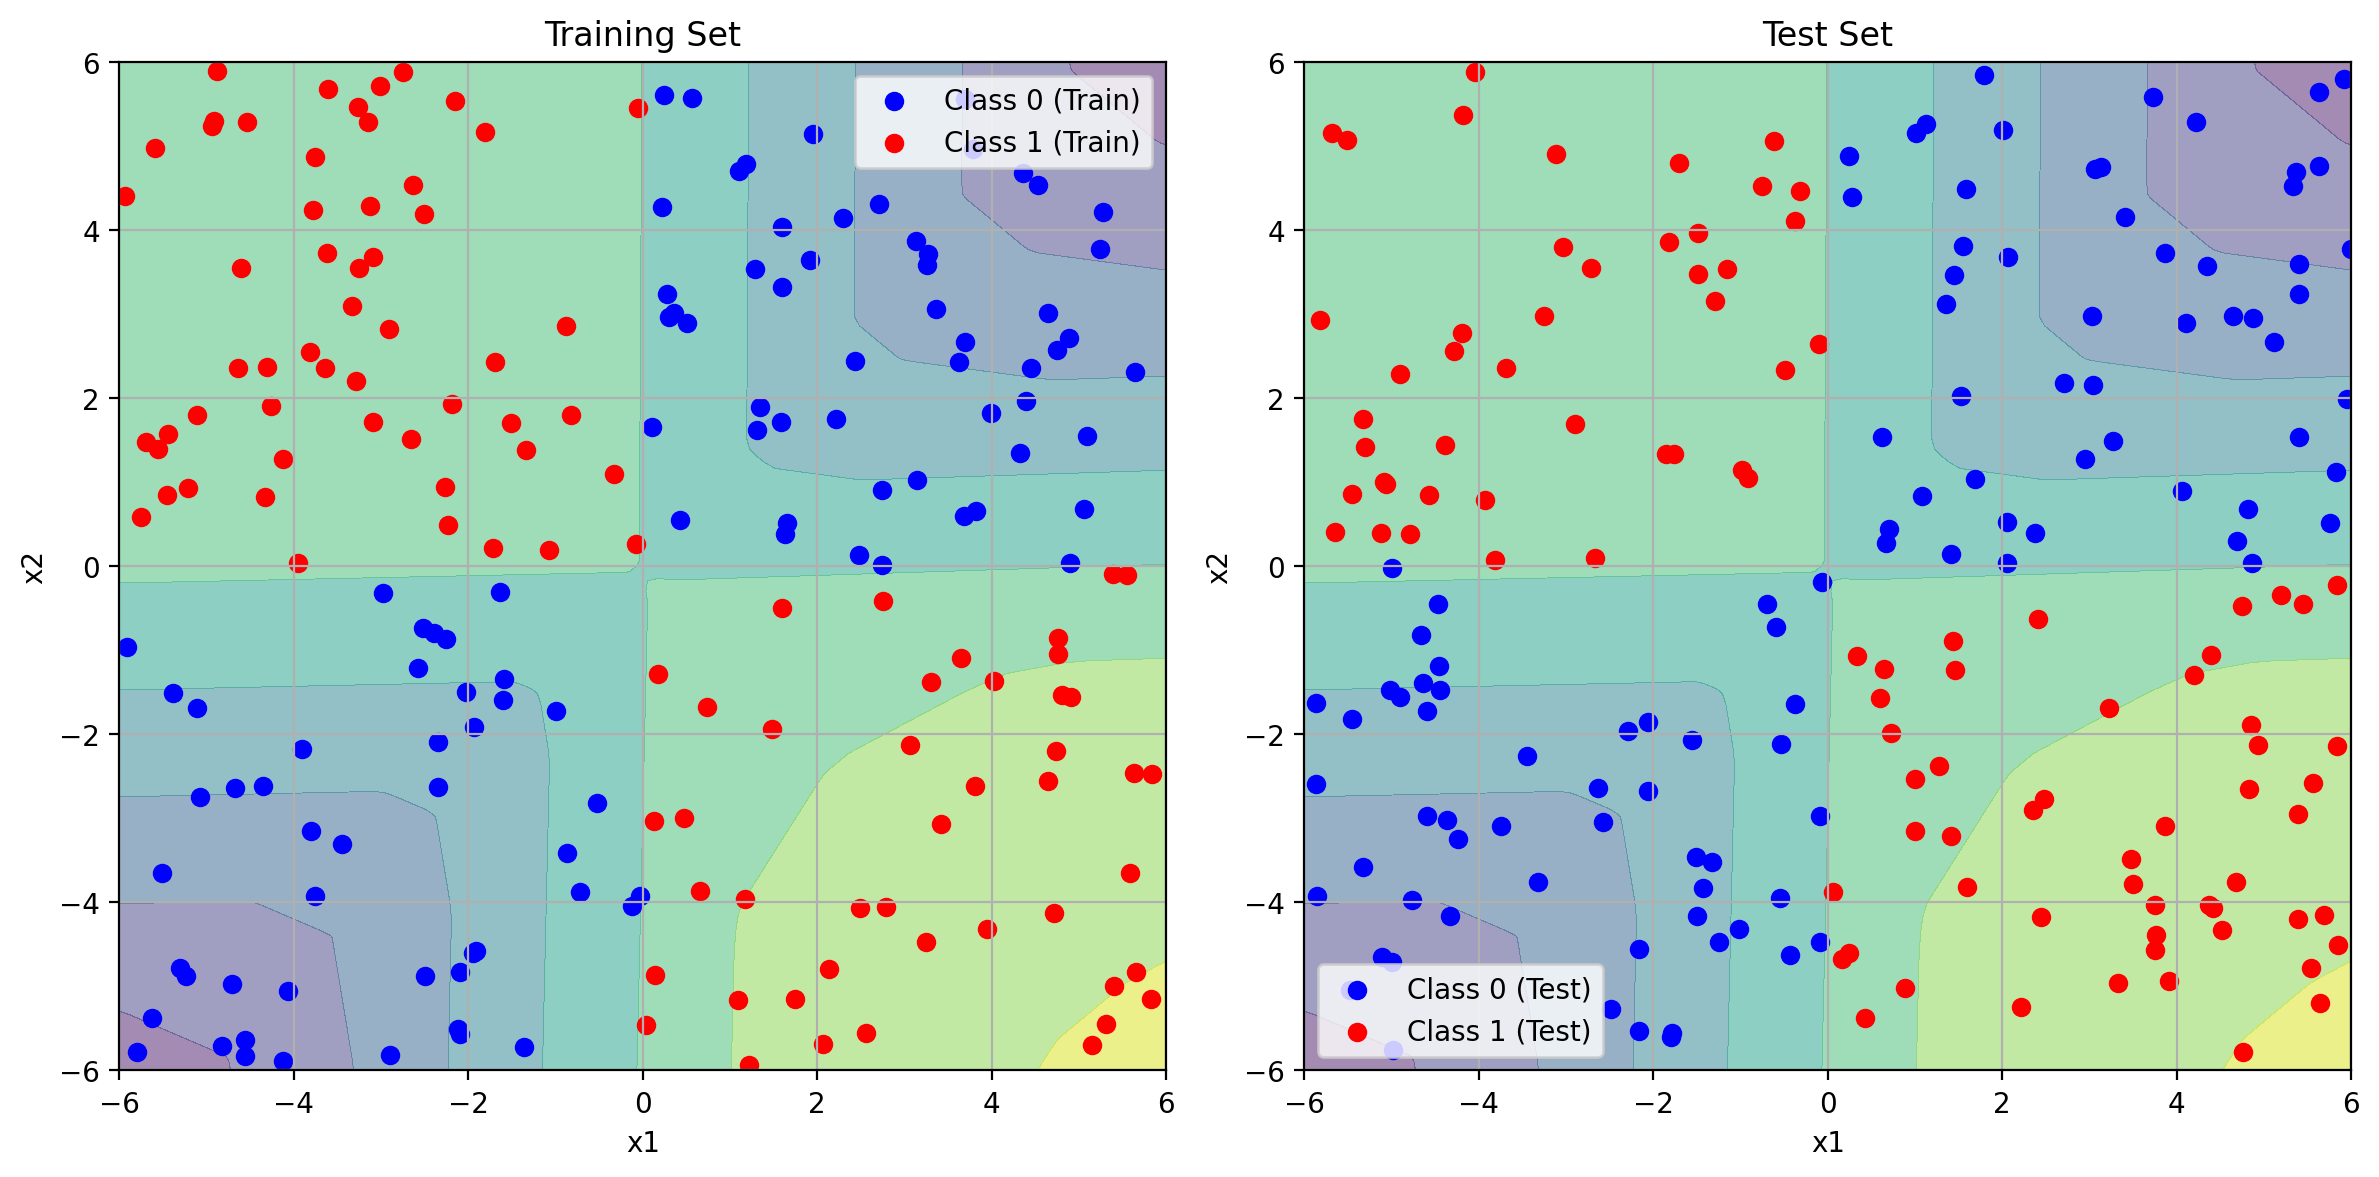

In [ ]:
plot_decision_surface(learned_model_l1, concatenated_x_train, y_train, concatenated_x_test, y_test, s=100)

# c

In [ ]:
def train_model_with_l2_reg(model, criterion, optimizer, x_train, y_train, num_epochs, batch_size, regularisation_coeff):
    for epoch in range(num_epochs):
        for i in range(0, x_train.shape[0], batch_size):
            x = torch.tensor(x_train, dtype=torch.float32)[i:i+batch_size]
            y = y_train[i:i+batch_size]
            outputs = model.forward(x)

            loss = criterion(outputs,y)
            l2_regularization = torch.tensor(0.)
            for param in model.parameters():
                l2_regularization += torch.norm(param, p=2)
            loss += regularisation_coeff * l2_regularization

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

    return model

In [ ]:
def accuracy(predicted,true_labels):
    result = torch.where(predicted > 0, torch.tensor(1), torch.tensor(0))
    accuracy = (result == true_labels).sum().item() / len(true_labels)
    return accuracy

In [ ]:
torch.manual_seed(1)
model_to_learn_l2 = MLP(2,4,1)
learned_model_l2 = train_model_with_l2_reg(model_to_learn_l2, nn.BCEWithLogitsLoss(), optim.SGD(model_to_learn_l2.parameters(), lr=0.01), concatenated_x_train, targets_train, 1000, 20, 0.01)
a3 = accuracy(learned_model_l2.forward(torch.tensor(concatenated_x_test, dtype=torch.float32)), targets_test)
print(f'Accuracy on the testing set: {a3*100:.2f} %')

Epoch 0, Loss: 0.8799701929092407
Epoch 100, Loss: 0.5537825226783752
Epoch 200, Loss: 0.24082395434379578
Epoch 300, Loss: 0.1742277890443802
Epoch 400, Loss: 0.15405093133449554
Epoch 500, Loss: 0.1458013951778412
Epoch 600, Loss: 0.1421385407447815
Epoch 700, Loss: 0.14043331146240234
Epoch 800, Loss: 0.13968269526958466
Epoch 900, Loss: 0.13941489160060883
Accuracy on the testing set: 99.00 %


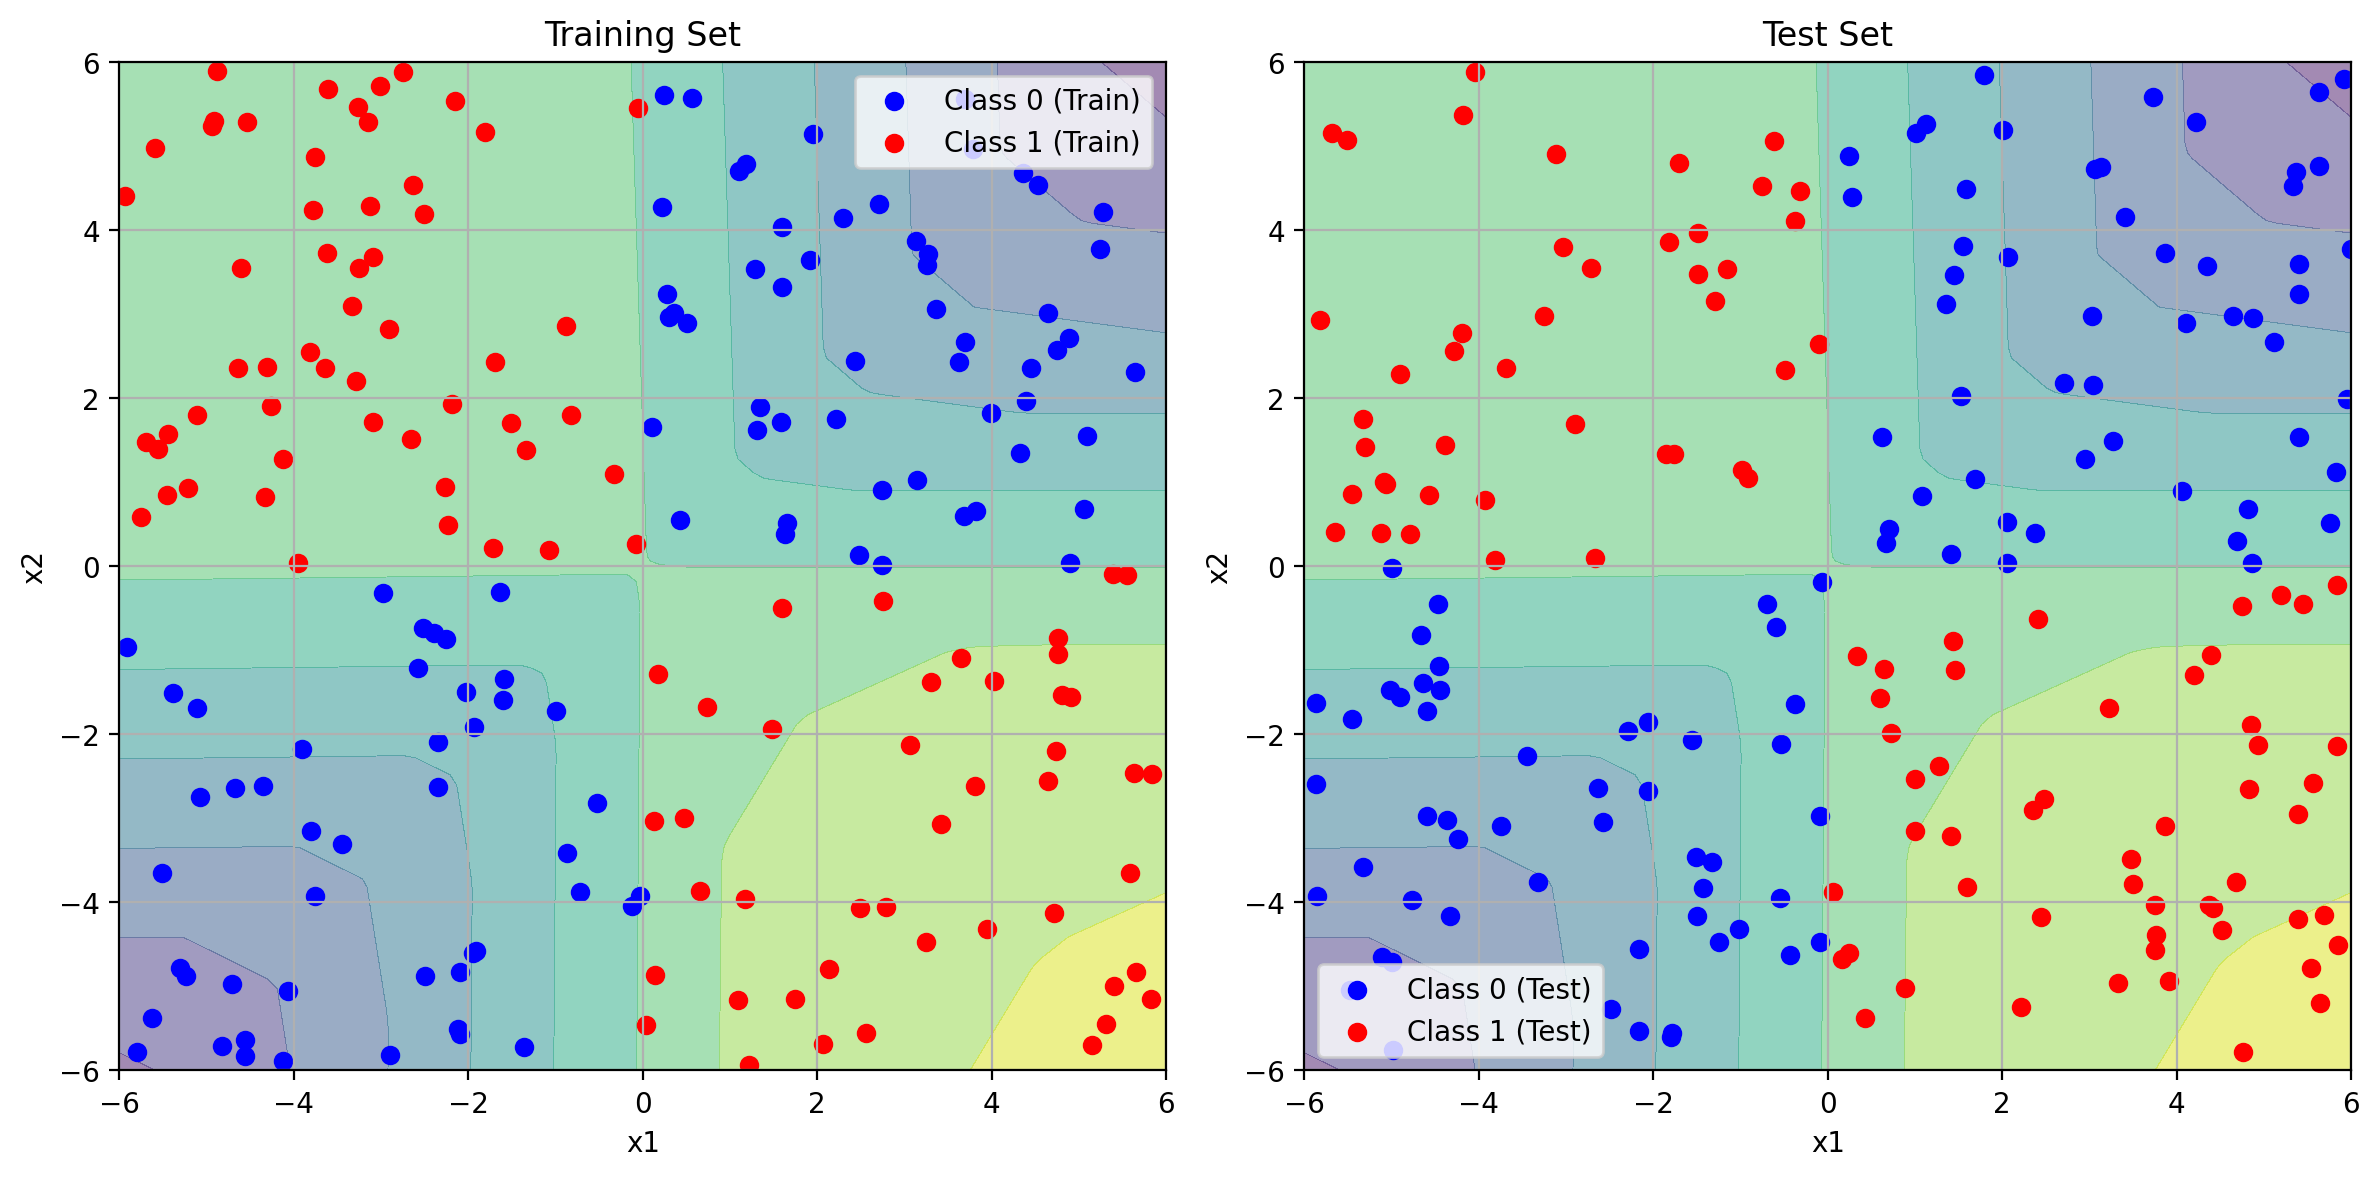

In [ ]:
plot_decision_surface(learned_model_l2, concatenated_x_train, y_train, concatenated_x_test, y_test, s=100)

## Part D. Learn logistic regression models on the same data with additional features (such as x1*x2, x1^2, etc.)

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os


In [27]:
x = np.random.uniform(low=-4, high=4, size=(400,2))
y = np.where(np.sign(x[:,0]).astype(int)*np.sign(x[:,1]).astype(int)>=0,1,0)


In [28]:
X_train = x[:170,:]
Y_train = y[:170]

X_val=x[170:200,:]
Y_val=y[170:200]

X_test = x[200:400,:]
Y_test = y[200:400]

In [29]:
import matplotlib.patches as mpatches
from sklearn.linear_model import LogisticRegression

In [30]:
clf = LogisticRegression(penalty=None,solver='newton-cg')

In [31]:
clf.fit(X_train,Y_train)

LogisticRegression(penalty=None, solver='newton-cg')

In [32]:
X = np.vstack((X_train[:, 0], X_train[:, 1])).T
y = Y_train
x_min, x_max = X_train[:, 0].min() - 0.3, X_train[:, 0].max() + 0.3
y_min, y_max = X_train[:, 0].min() - 0.3, X_train[:, 0].max() + 0.3
h = 0.02
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))


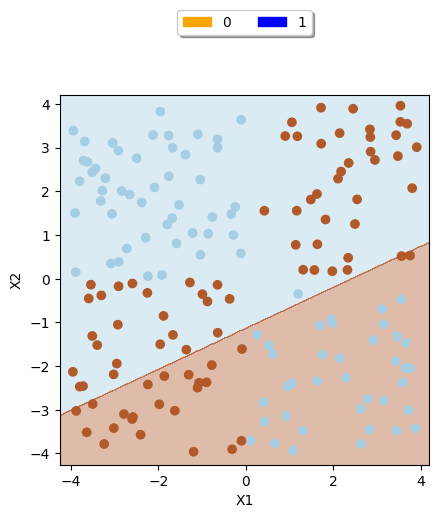

In [33]:
Z=clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
yellow_patch = mpatches.Patch(color='orange', label='0')
blue_patch = mpatches.Patch(color='blue', label='1')
plt.legend(handles=[yellow_patch, blue_patch], loc='upper center',bbox_to_anchor=(0.5, 1.25),ncol=2, fancybox=True, shadow=True)
plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.4)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
plt.xlabel('X1')
plt.ylabel('X2')
plt.gca().set_aspect('equal', adjustable='box')

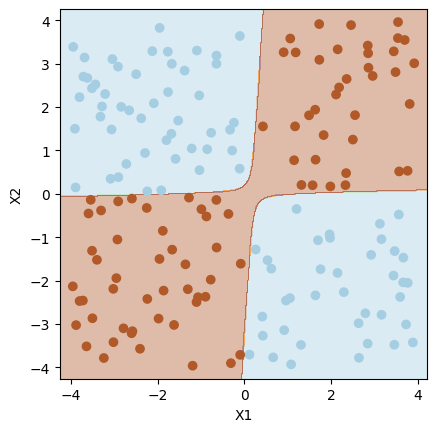

In [34]:
# Add new features
X_train_extended = np.hstack((X_train,
                              (X_train[:, 0] * X_train[:, 1])[:, None],  # Reshape to (170, 1)
                              (X_train[:, 0]**2)[:, None],         # Reshape to (170, 1)
                              (X_train[:, 1]**2)[:, None]))        # Reshape to (170, 1)
# print(X_train_extended)

# Apply the same changes to X_val_extended and X_test_extended
X_val_extended = np.hstack((X_val,
                            (X_val[:, 0] * X_val[:, 1])[:, None],
                            (X_val[:, 0]**2)[:, None],
                            (X_val[:, 1]**2)[:, None]))

X_test_extended = np.hstack((X_test,
                             (X_test[:, 0] * X_test[:, 1])[:, None],
                             (X_test[:, 0]**2)[:, None],
                             (X_test[:, 1]**2)[:, None]))

# Train logistic regression with extended features
clf = LogisticRegression(penalty=None, solver='newton-cg')
clf.fit(X_train_extended, Y_train)

# ... (Rest of your code for plotting the decision boundary) ...

# Create meshgrid for plotting
X = np.vstack((X_train_extended[:, 0], X_train_extended[:, 1])).T
y = Y_train
x_min, x_max = X_train_extended[:, 0].min() - 0.3, X_train_extended[:, 0].max() + 0.3
y_min, y_max = X_train_extended[:,1].min() - 0.3, X_train_extended[:,1].max() + 0.3
h = 0.02
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Predict on meshgrid
Z = clf.predict(np.c_[xx.ravel(), yy.ravel(), (xx.ravel() * yy.ravel()), xx.ravel()**2, yy.ravel()**2])
Z = Z.reshape(xx.shape)

# Plot decision boundary and data points
plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.4)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
plt.xlabel('X1')
plt.ylabel('X2')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()